In [1]:
################################
# Scientific imports
################################
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astroquery.mast import Observations
from astroquery.mast import Catalogs

###
# General imports
###
import csv, math, io, os, os.path, sys, random, time
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange

###
# SciKitLearn Imports
###
import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from IPython.display import display

################################
# MatPlotLib Settings
################################
plt.rcParams["figure.figsize"] = (20,9)
sb.set()

################################
# Initialisers
################################

# Load the Data files
fitsarr = np.load("fitslist.npy")
fluxarr = np.load("fluxlist.npy")
#planetarr = np.load("planetlist.npy")
isplanetarr = np.load("isplanetlist.npy")

In [2]:
def DrawLC(rndFile=-1):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']
        obj       = hdulist[0].header['OBJECT']
        sector    = hdulist[0].header['SECTOR']


        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds     = hdulist[1].data['TIME']
        sap_fluxes    = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # X- and Y- labels
    ylab = "PDCSAP Flux (e-/s)"
    xlab = "Time (TBJD)"

    #ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)
    return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector), ylab, xlab)

Text(0, 0.5, 'PDCSAP Flux (e-/s)')

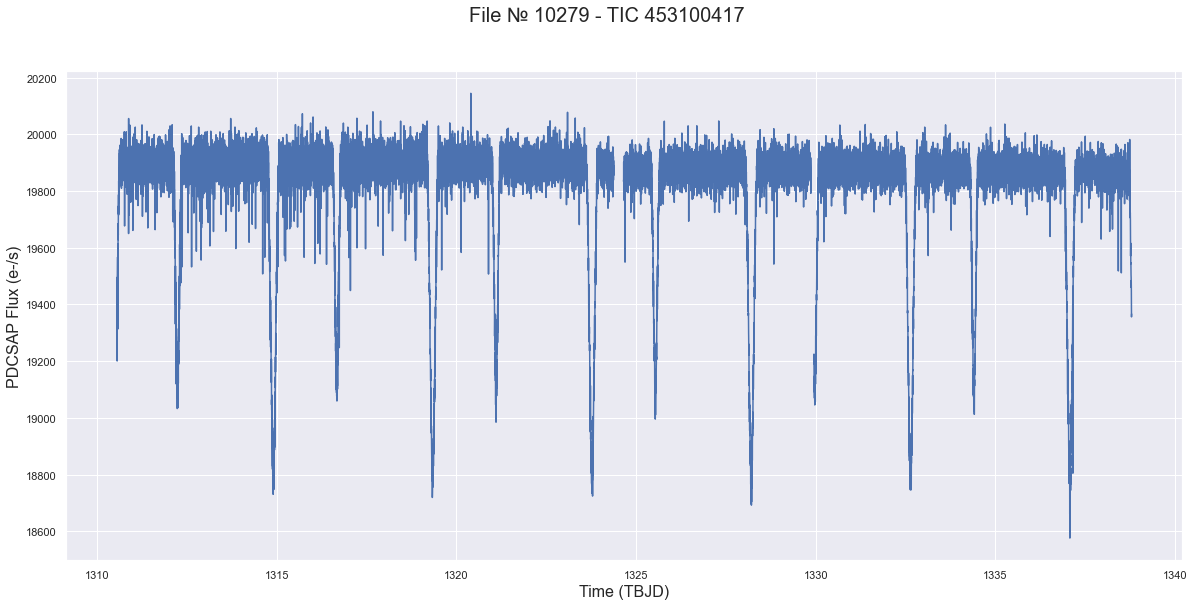

In [3]:
x,y,f,o,s,ylab,xlab = DrawLC(10279)

fig, ax = plt.subplots()

ax.plot(x,y)

fig.suptitle("File № {} - {}".format(f, o), fontsize=20) # + str(obj) + " - Sector " + str(sector))

ax.set_xlabel(xlab, fontsize=16)
ax.set_ylabel(ylab, fontsize=16)

In [4]:
fitsarr[int(f)]

'SIM_DATA/tess2018191215100-s0001-0000000453100417-0001-a_lc.fits'

In [28]:
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
ts = TimeSeries.read(fitsarr[int(f)], format='tess.fits')  

periodogram = BoxLeastSquares.from_timeseries(ts, 'pdcsap_flux')

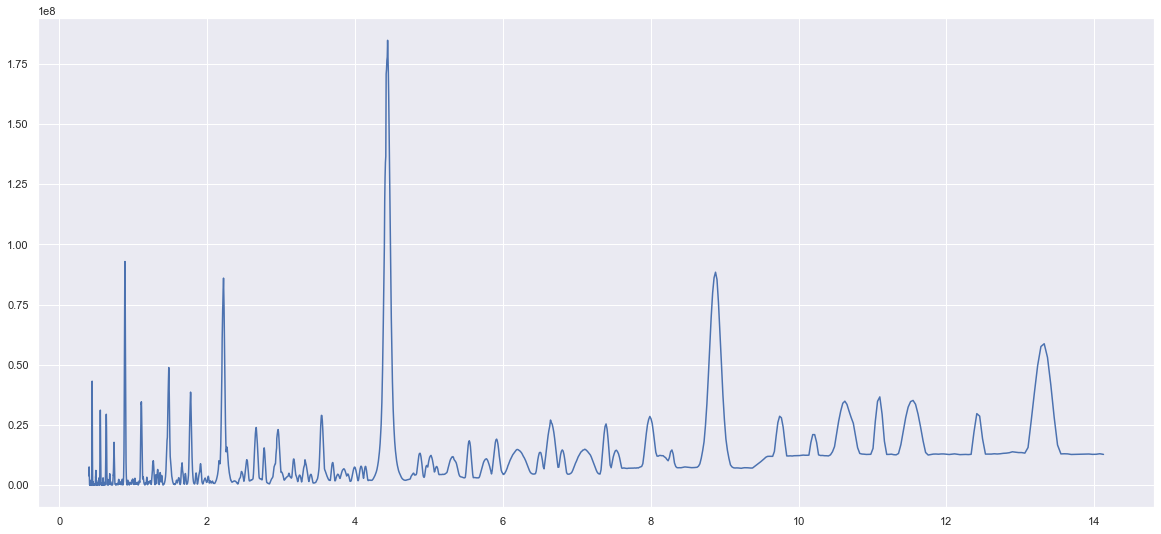

In [29]:
plt.plot(results.period, results.power)

# find where highest (2) peaks are, how large, where are they in the TS

### size of box (0.2 * u.day) is a tuneable param

Text(0, 0.5, 'PDCSAP Flux (e-/s)')

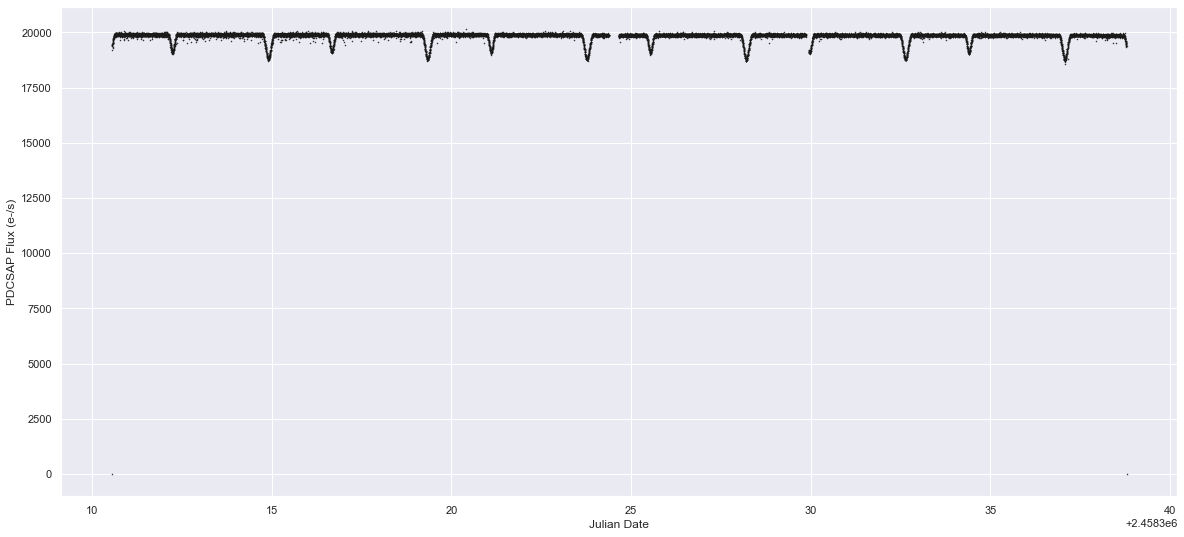

In [31]:
plt.plot(ts.time.jd, ts['pdcsap_flux'], 'k.', markersize=1)
plt.xlabel('Julian Date')
plt.ylabel('PDCSAP Flux (e-/s)')

In [32]:
results = periodogram.autopower(0.2 * u.day)  
best = np.argmax(results.power)  
period = results.period[best]  
period

<Quantity 4.43572517 d>

In [33]:
transit_time = results.transit_time[best]  
transit_time

<Time object: scale='tdb' format='isot' value=2018-07-15T09:22:42.917>

In [34]:
ts_folded = ts.fold(period=period, epoch_time=transit_time)

Text(0, 0.5, 'SAP Flux (e-/s)')

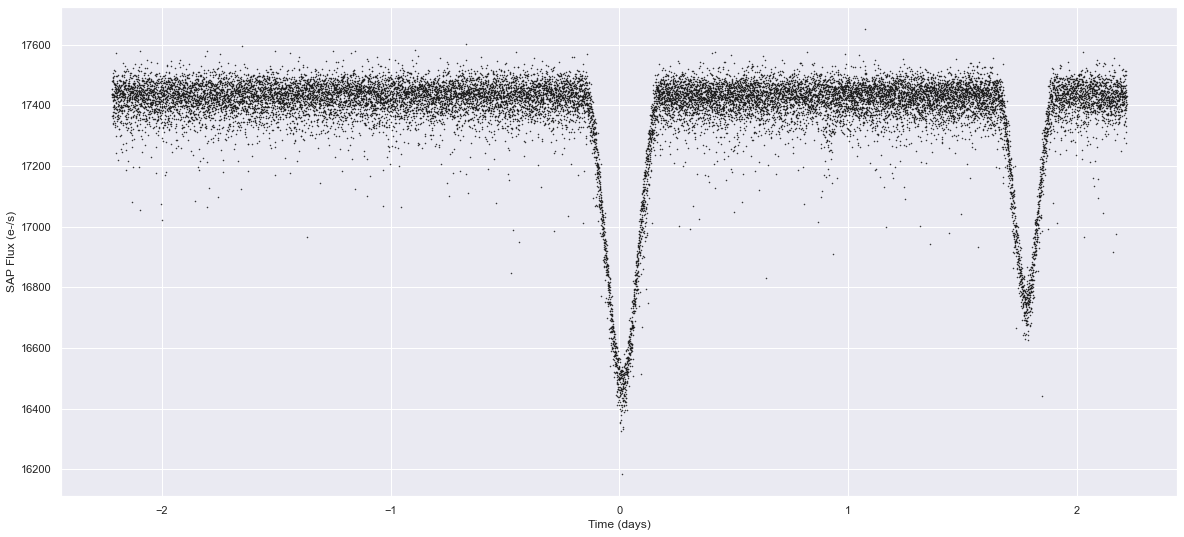

In [35]:
plt.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
plt.xlabel('Time (days)')
plt.ylabel('SAP Flux (e-/s)')

### IT LOOKS LIKE THIS WORKS HOLY SHIT  
(Jean is also very proud of me) <3  
### So I can take this approach in the future and get a folded LC function. This is... big, actually.
#### Next step - see how this looks with garbage data and stuff, and can then see how it affects things - might then be much more worthwhile to peform this step before applying the ML algorithm. CAN THEN DO ACCURACY WOO

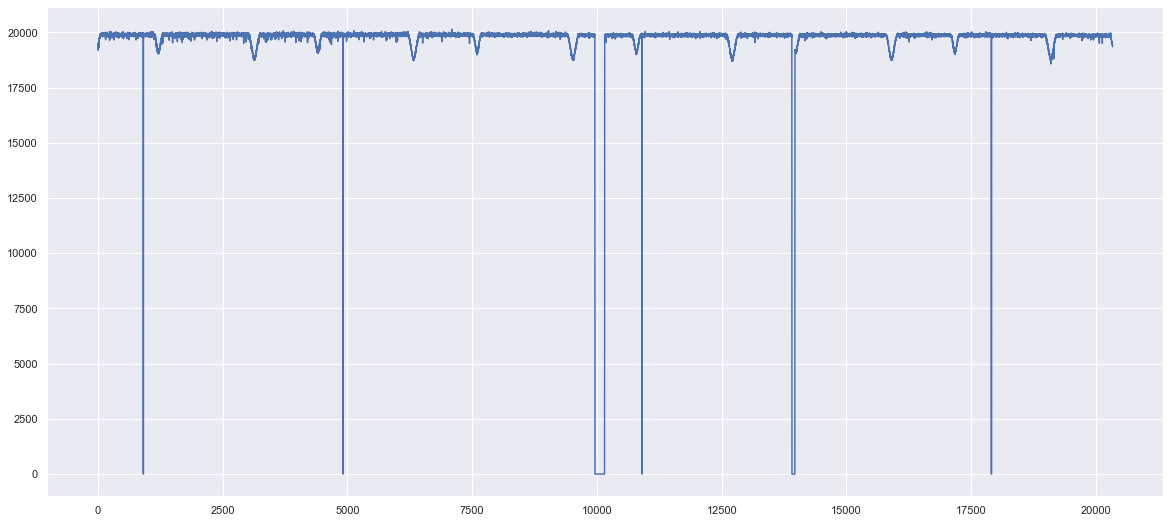

In [14]:
plt.plot(y)

In [39]:
def FTTPipeline(x,y):
    """
    Function that takes in a timeseries and then outputs a Fourier Transformed version of it
    """
    
    # First, change all 0s to NANs
    #ynew = [idx for idx, element in enumerate(y) if element == 0]
    #y[y==0] = np.nan
    
    # Is this required?
    TMP = np.correlate(y-np.mean(y),y-np.mean(y),mode='full')
    
    # FOURIER TRANSFORM THAT Y (remember to use np.nanmean instead of np.mean)
    FTY = np.fft.fft(y-np.mean(y))
    powSpectrum = np.abs(FTY)
    
    # Get Delta D
    delta_d = np.nanmean(np.diff(x))
    #print(delta_d)
    
    # DO THE THING
    F=np.fft.fftfreq(len(y),delta_d)
    plt.plot(F,powSpectrum)
    return(F,powSpectrum,delta_d)

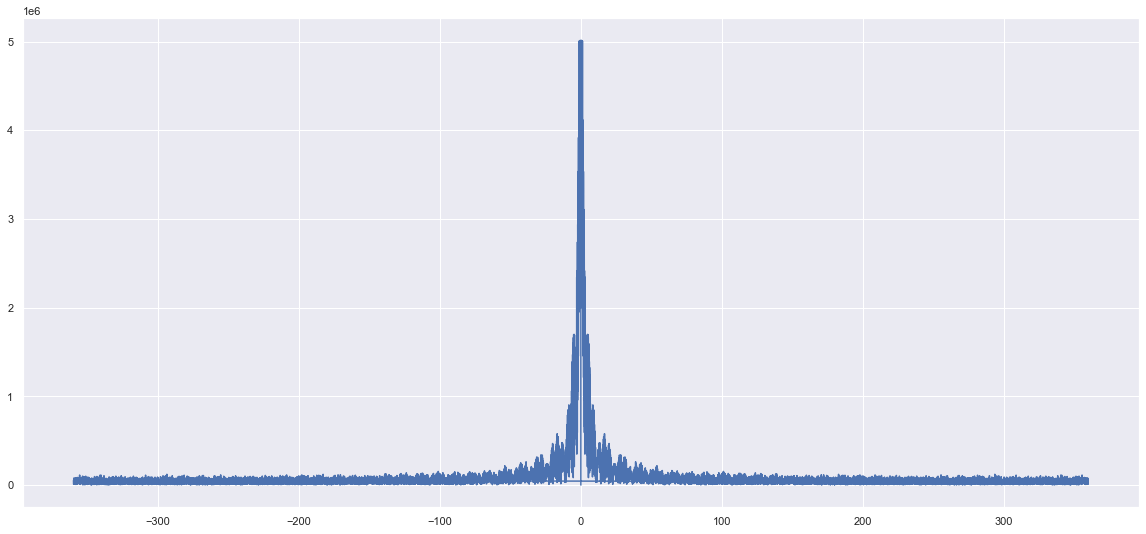

In [40]:
x,y,f,o,s,_,_ = DrawLC(10279)
xn, yn, delta_d = FTTPipeline(x,y)
#plt.xlim(0,10)

(-10.0, 10.0)

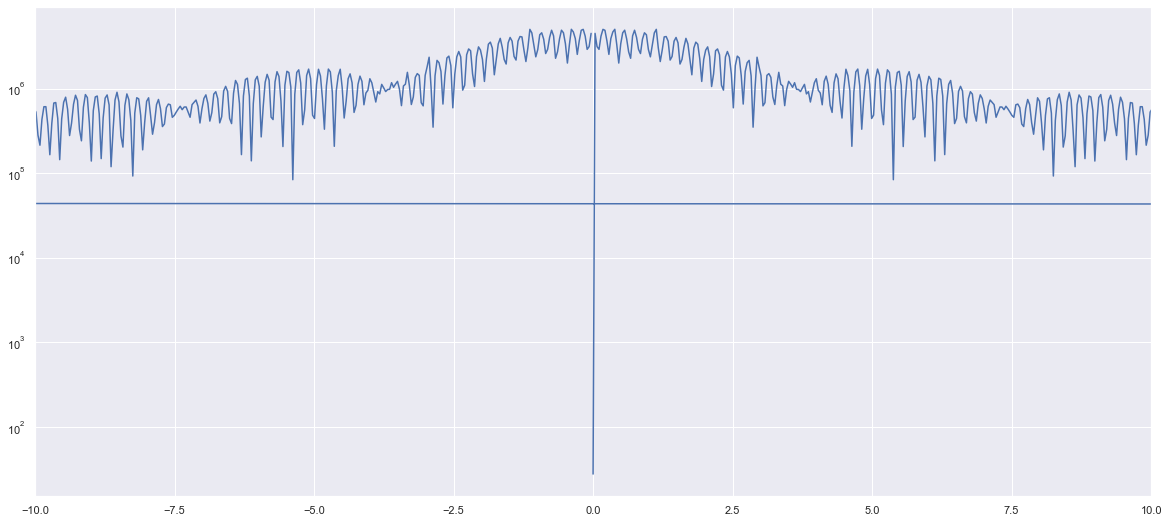

In [41]:
plt.semilogy(xn,yn)
plt.xlim([-10,10])

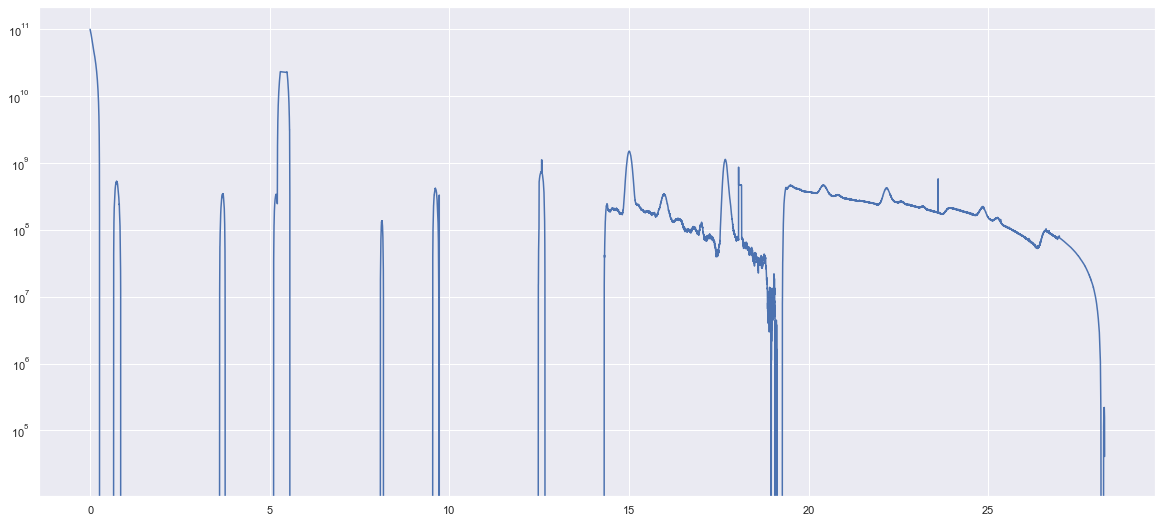

In [42]:
TMP = np.correlate(y-np.mean(y),y-np.mean(y),mode='full')
plt.semilogy(np.arange(len(y)-1)*delta_d,TMP[len(y):])

In [43]:
len(xn)

20338

In [44]:
len(yn)

20338

In [45]:
xn

array([ 0.        ,  0.0354023 ,  0.0708046 , ..., -0.10620691,
       -0.0708046 , -0.0354023 ])

In [46]:
xn[0:len(xn)//2]

array([0.00000000e+00, 3.54023020e-02, 7.08046039e-02, ...,
       3.59899802e+02, 3.59935204e+02, 3.59970606e+02])

In [47]:
xn[len(xn)//2:]

array([-3.60006009e+02, -3.59970606e+02, -3.59935204e+02, ...,
       -1.06206906e-01, -7.08046039e-02, -3.54023020e-02])

In [48]:
xfold = xn.copy()

In [49]:
xfold

array([ 0.        ,  0.0354023 ,  0.0708046 , ..., -0.10620691,
       -0.0708046 , -0.0354023 ])